In [35]:
import pandas as pd

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



In [36]:
SOURCE_TWITTER_PATH = "./full_data/data_storage/full_train_source_only.json"
FULL_TWITTER_PATH = "./full_data/data_storage/full_train.json"
Y_TRAIN_PATH = "./id_data/train.label.txt"
X_TRAIN_PATH = "./id_data/train.data.txt"   # train
SOURCE_STORY_ONLY = True

In [37]:
def join_data_id_label(LABEL_PATH, ID_PATH, DATA_PATH, dropna_on_column="text", SOURCE_STORY_ONLY=True):
    """A function that joins data and id and their labels, return a dataframe that trims off twitter we don't have data"""
    # Process Labels
    if LABEL_PATH:
        # 1: Rumour
        # 0: NonRumour
        with open(LABEL_PATH, "r") as f:
            y_label = f.read().strip().split("\n") # remove next line
        y_label = pd.DataFrame(y_label, columns = ["label"])
        y_label[y_label["label"]=="rumour"] = 1
        y_label[y_label["label"]=="nonrumour"] = 0
    
    
    ## Get Dataframe Id
    total_id_list = []
    with open(ID_PATH, "r") as f:
        for line in f:
            line = line.strip() # remove next line
            if SOURCE_STORY_ONLY:
                line = line.split(',')[0] # split into list\
            else:
                line = line.split(',')
            total_id_list.append(line)
            
    if not SOURCE_STORY_ONLY:
        total_id_list = [item for sublist in total_id_list for item in sublist] # Flat into a single list
    total_id_list = total_id_list
    id_df = pd.DataFrame(total_id_list, columns=["id"])
    id_df["id"] = id_df["id"].astype(str)
    # join their labels
    if LABEL_PATH:
    # if we are processing testing data, don't add label
        id_df["label"] = y_label["label"]
    
    ## Get Twitter Data
    # Read Source Data
    data_df = pd.read_json(DATA_PATH)
    #source_df = pd.concat([source_df, y_train], axis=1)
    data_df["id"] = data_df["id"].astype(str)
    
    ## Join the data file and IDs we got 
    ## Drop rows we don't have data on
    combined_df = id_df.join(data_df.set_index('id'), on='id')
    if dropna_on_column:
        combined_df = combined_df.dropna(subset=['text', 'author_id']).reset_index(drop=True)
    combined_df.reindex(total_id_list) # make sure we have the right order
    return combined_df

In [38]:
def Remove_URL(original):
    """Remove url link in the text"""
    result = re.sub(r"http\S+", "", original)
    result = re.sub(r"www.\S+", "", result)
    result = re.sub(r"wasap.my+", "", result)
    return result

In [39]:
# Reference: https://stackoverflow.com/questions/27084617/detect-strings-with-non-english-characters-in-python
def isEnglish(s):
    s = str(s)
    """Check if a string is english"""
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [40]:
## Remove Stopwords
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()

def text_processing(input_str):
    """A function takes a input text string and output a list of preprocessed words
        1. Remove URL
        2. StopWords Removal
        3. Remove Non-English Words
        4. Remove Numeric Value
        5. Lemmatize
    
    """
    list_words = []
    # Remove URL
    input_str = Remove_URL(input_str)
    for word in re.sub(r'[^\w\s]','', input_str).split():
        # Remove Numeric Value, Non-English words and Stop words
        if (word.isalpha()) and (isEnglish(word)) and (word not in stopwords.words('english')):
            # Remove Links in the text
            # Lemmatize words
            word = lemmatizer.lemmatize(word)
            # Add to List
            list_words.append(word)
    return list_words

#filtered_words = [word for word in word_list if word not in stopwords.words('english')]

In [41]:
## Expand list of words into bag-of-words array
def get_bag_of_words(df_column):
    """Expand list of words into bag-of-words array, return the dataframe."""
    return pd.get_dummies(df_column.apply(pd.Series).stack()).groupby(level=0).sum()


In [42]:
# Load Data
X_train = join_data_id_label(Y_TRAIN_PATH, X_TRAIN_PATH, SOURCE_TWITTER_PATH)


In [43]:
print(X_train[["lang"]].value_counts())
print("============")
print(X_train[["withheld"]].value_counts())
print("============")
print(X_train[["reply_settings"]].value_counts())
print("============")
print(X_train[["source"]].value_counts())

## Only keep English! 

lang
en      1547
und        4
es         2
in         2
ro         2
hu         1
it         1
ja         1
ru         1
zh         1
dtype: int64
withheld
False       1551
True          11
dtype: int64
reply_settings
everyone          1562
dtype: int64
source                 
Twitter Web App            406
Twitter for Android        291
Twitter for iPhone         286
TweetDeck                  165
Twitter Web Client         110
                          ... 
The New York Times           1
TheLatestIs                  1
TweetCaster for Android      1
Sendible                     1
AOL Blogsmith                1
Length: 61, dtype: int64


###  Standard Scaler to do PCA to do dimension reduction

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [45]:
## Standardize, why? it needs to do to use PCA, also, it needs to have variance of 1
scaler = StandardScaler()

pca = PCA(n_components=200, random_state=5)

pca600 = PCA(n_components=1000, random_state=5)

# Only Use Text Data
other fields including author information, entities, public matrix, and source not used!

### Process Training Data use above functions

In [46]:
## How to normalize json field in the data? 

## NOT YET USED!
#pd.json_normalize(X_train['public_metrics']).head(3)

In [47]:
# Load Data
X_train = join_data_id_label(Y_TRAIN_PATH, X_TRAIN_PATH, SOURCE_TWITTER_PATH)
X_train

,id,label,created_at,author_id,lang,reply_settings,source,withheld,public_metrics,entities,text
0,1250219300389974016,0,2020-04-15 00:28:03+00:00,3.123627e+08,en,everyone,Twitter Web App,False,"{'retweet_count': 0, 'reply_count': 1, 'like_c...","{'urls': [{'start': 96, 'end': 119, 'url': 'ht...",5. Can regularly rinsing your nose with saline...
1,554886875303780352,1,2015-01-13 06:25:15+00:00,1.634397e+07,en,everyone,TweetDeck,False,"{'retweet_count': 184, 'reply_count': 35, 'lik...","{'urls': [{'start': 62, 'end': 84, 'url': 'htt...",French police chief killed himself after #Char...
2,1237901309011021825,0,2020-03-12 00:40:45+00:00,2.850483e+08,en,everyone,Twitter Web App,False,"{'retweet_count': 1, 'reply_count': 1, 'like_c...","{'urls': [{'start': 186, 'end': 209, 'url': 'h...",Coronavirus disease (COVID-19) advice for the ...
3,524958128392376320,0,2014-10-22 16:19:05+00:00,3.108351e+06,en,everyone,SocialFlow,False,"{'retweet_count': 121, 'reply_count': 5, 'like...","{'annotations': [{'start': 0, 'end': 5, 'proba...",Ottawa police confirm that there were multiple...
4,1239295488677085185,0,2020-03-15 21:00:44+00:00,1.053802e+18,en,everyone,Twitter for iPhone,False,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",None,if the primary focus of a government isn't to ...
...,...,...,...,...,...,...,...,...,...,...,...
1557,1237545128828342277,0,2020-03-11 01:05:25+00:00,8.225705e+08,en,everyone,Twitter Web App,False,"{'retweet_count': 0, 'reply_count': 1, 'like_c...","{'annotations': [{'start': 58, 'end': 62, 'pro...",4. It cannot be transmitted through goods manu...
1558,671181758692507648,1,2015-11-30 04:19:35+00:00,4.876003e+08,en,everyone,Mobile Web,False,"{'retweet_count': 76, 'reply_count': 30, 'like...","{'urls': [{'start': 101, 'end': 124, 'url': 'h...",Desperate Ted Cruz Claims Planned Parenthood S...
1559,672513234419638273,1,2015-12-03 20:30:24+00:00,2.878549e+07,en,everyone,Twitter Web Client,False,"{'retweet_count': 108, 'reply_count': 36, 'lik...","{'annotations': [{'start': 45, 'end': 49, 'pro...","""Thoughts and prayers are not enough."" Pres. O..."
1560,553508098825261056,0,2015-01-09 11:06:29+00:00,1.417332e+07,en,everyone,Hootsuite,False,"{'retweet_count': 176, 'reply_count': 9, 'like...","{'urls': [{'start': 94, 'end': 116, 'url': 'ht...",Police have surrounded this building where the...


In [48]:

## 1. Only keep english tweets as most of them are in english
## 2. Based on the values count, drop irrelevant features "reply_settings" too
X_train = X_train[X_train.lang=="en"].reset_index(drop=True)
X_train = X_train[['id','lang', 'text','label']]
# Use only text data and tokenize
X_train["clean_text"] = X_train["text"].apply(text_processing)
X_train.head(5)

,id,lang,text,label,clean_text
0,1250219300389974016,en,5. Can regularly rinsing your nose with saline...,0,"[Can, regularly, rinsing, nose, saline, help, ..."
1,554886875303780352,en,French police chief killed himself after #Char...,1,"[French, police, chief, killed, CharlieHebdo, ..."
2,1237901309011021825,en,Coronavirus disease (COVID-19) advice for the ...,0,"[Coronavirus, disease, advice, public, Should,..."
3,524958128392376320,en,Ottawa police confirm that there were multiple...,0,"[Ottawa, police, confirm, multiple, suspect, s..."
4,1239295488677085185,en,if the primary focus of a government isn't to ...,0,"[primary, focus, government, isnt, alleviate, ..."


In [49]:
# Load Data
X_train = join_data_id_label(Y_TRAIN_PATH, X_TRAIN_PATH, SOURCE_TWITTER_PATH)


## 1. Only keep english tweets as most of them are in english
## 2. Based on the values count, drop irrelevant features "reply_settings" too
X_train = X_train[X_train.lang=="en"].reset_index(drop=True)
X_train = X_train[['id','lang', 'text','label']]
# Use only text data and tokenize
X_train["clean_text"] = X_train["text"].apply(text_processing)
# Get BOF dataframe
X_train_BOW = get_bag_of_words(X_train["clean_text"])
X_train_BOW.head(5)

,A,AB,ABC,ABCNews,ABOUT,AC,ACCORDING,ACCURATE,ACTED,AFFECT,...,youd,young,younger,yourbabazg,youre,youve,zaelefty,zero,zoom,zwinst
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Get train test data
y_train = X_train["label"].astype(int)
X_train = X_train_BOW

assert(len(X_train) == len(y_train))

In [51]:
## Transform using Train Data

train_columns = X_train.columns

# StandardScaler
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=train_columns)

# PCA
X_train_scaled_reduced = pd.DataFrame(pca.fit_transform(X_train_scaled))

X_train_scaled_reduced_pca600 = pd.DataFrame(pca600.fit_transform(X_train_scaled))

### Dev Data Load

In [52]:
def keep_training_columns_only(test_BOW_df, train_column, default_value=0):
    """Take a BOW dataframe and keep only the words from training dataframe, return a dataframe"""
    return test_BOW_df.reindex(columns = train_columns, fill_value=0)

In [53]:
DEV_SOURCE_TWITTER_PATH = "./full_data/data_storage/full_dev_source_only.json"
#DEV_FULL_TWITTER_PATH = "./full_data/data_storage/full_dev.json"
Y_DEV_PATH = "./id_data/dev.label.txt"
X_DEV_PATH = "./id_data/dev.data.txt"

In [54]:
# Load Data
X_dev = join_data_id_label(Y_DEV_PATH, X_DEV_PATH, DEV_SOURCE_TWITTER_PATH)


## 1. Only keep english tweets as most of them are in english
## 2. Based on the values count, drop irrelevant features "reply_settings" too
X_dev = X_dev[X_dev.lang=="en"].reset_index(drop=True)
X_dev = X_dev[['id','lang', 'text','label']]
# Use only text data and tokenize
X_dev["clean_text"] = X_dev["text"].apply(text_processing)
# Get BOF dataframe
X_dev_BOW = get_bag_of_words(X_dev["clean_text"])

## Keep training columns only
X_dev_BOW = keep_training_columns_only(X_dev_BOW, train_columns, default_value=0)

X_dev_BOW.head(5)

,A,AB,ABC,ABCNews,ABOUT,AC,ACCORDING,ACCURATE,ACTED,AFFECT,...,youd,young,younger,yourbabazg,youre,youve,zaelefty,zero,zoom,zwinst
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Get train test data
y_dev = X_dev["label"].astype(int)
X_dev = X_dev_BOW

assert(len(X_dev) == len(y_dev))

In [56]:
## Transform using Trained Transformer

# StandardScaler
X_dev_scaled = pd.DataFrame(scaler.transform(X_dev), columns=train_columns)

# PCA
X_dev_scaled_reduced = pd.DataFrame(pca.transform(X_dev_scaled))
X_dev_scaled_reduced_pca600 = pd.DataFrame(pca600.transform(X_dev_scaled))

# ML Models Fit

## Without PCA

In [57]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [176]:
mlp_clf = MLPClassifier() # early_stopping=True
mlp_clf.fit(X_train_scaled, y_train)

Train_Score = mlp_clf.score(X_train_scaled, y_train) # X_train_scaled_reduced for PCA
Test_Score = mlp_clf.score(X_dev_scaled, y_dev) # X_dev_scaled_reduced for PCA
print("Train Score: ", Train_Score)
print("Test Score: ", Test_Score)

valid_pred = mlp_clf.predict(X_dev_scaled)
Y_valid = y_dev
rf_precision = precision_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Precision score: %f " % rf_precision)
rf_recall = recall_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Recall score: %f " % rf_recall)
rf_f1 = f1_score(Y_valid, valid_pred, average = "macro")
print("RF Macro F1 score: %f " % rf_f1)


train_pred = mlp_clf.predict(X_train_scaled)
rf_f1 = f1_score(y_train, train_pred, average = "macro")
print("Train Macro F1 score: %f " % rf_f1)

Train Score:  0.9993535875888817
Test Score:  0.8984962406015038
RF Macro Precision score: 0.862739 
RF Macro Recall score: 0.823764 
RF Macro F1 score: 0.840951 
Train Macro F1 score: 0.999009 


In [177]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_scaled, y_train)  # X_train_scaled_reduced for PCA

Train_Score = lr_clf.score(X_train_scaled, y_train)  # X_train_scaled_reduced for PCA
Test_Score = lr_clf.score(X_dev_scaled, y_dev)   # X_dev_scaled_reduced for PCA

print("Train Score: ", Train_Score)
print("Test Score: ", Test_Score)

valid_pred = lr_clf.predict(X_dev_scaled)
Y_valid = y_dev
rf_precision = precision_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Precision score: %f " % rf_precision)
rf_recall = recall_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Recall score: %f " % rf_recall)
rf_f1 = f1_score(Y_valid, valid_pred, average = "macro")
print("RF Macro F1 score: %f " % rf_f1)


train_pred = lr_clf.predict(X_train_scaled)
rf_f1 = f1_score(y_train, train_pred, average = "macro")
print("Train Macro F1 score: %f " % rf_f1)

Train Score:  1.0
Test Score:  0.9172932330827067
RF Macro Precision score: 0.917039 
RF Macro Recall score: 0.829346 
RF Macro F1 score: 0.863485 
Train Macro F1 score: 1.000000 


In [178]:
svm_clf = SVC()
svm_clf.fit(X_train_scaled, y_train)

Train_Score = svm_clf.score(X_train_scaled, y_train) # X_train_scaled_reduced for PCA
Test_Score = svm_clf.score(X_dev_scaled, y_dev) # X_dev_scaled_reduced for PCA
print("Train Score: ", Train_Score)
print("Test Score: ", Test_Score)


valid_pred = svm_clf.predict(X_dev_scaled)
Y_valid = y_dev
rf_precision = precision_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Precision score: %f " % rf_precision)
rf_recall = recall_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Recall score: %f " % rf_recall)
rf_f1 = f1_score(Y_valid, valid_pred, average = "macro")
print("RF Macro F1 score: %f " % rf_f1)


train_pred = svm_clf.predict(X_train_scaled)
rf_f1 = f1_score(y_train, train_pred, average = "macro")
print("Train Macro F1 score: %f " % rf_f1)

Train Score:  0.9883645765998708
Test Score:  0.8157894736842105
RF Macro Precision score: 0.905039 
RF Macro Recall score: 0.570175 
RF Macro F1 score: 0.570614 
Train Macro F1 score: 0.981802 


## PCA = 200

In [171]:
mlp_clf = MLPClassifier() # early_stopping=True
mlp_clf.fit(X_train_scaled_reduced, y_train) # X_train_scaled_reduced for PCA

Train_Score = mlp_clf.score(X_train_scaled_reduced, y_train) # X_train_scaled_reduced for PCA
Test_Score = mlp_clf.score(X_dev_scaled_reduced, y_dev) # X_dev_scaled_reduced for PCA
print("Train Score: ", Train_Score)
print("Test Score: ", Test_Score)

valid_pred = mlp_clf.predict(X_dev_scaled_reduced)
Y_valid = y_dev
rf_precision = precision_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Precision score: %f " % rf_precision)
rf_recall = recall_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Recall score: %f " % rf_recall)
rf_f1 = f1_score(Y_valid, valid_pred, average = "macro")
print("RF Macro F1 score: %f " % rf_f1)


train_pred = mlp_clf.predict(X_train_scaled_reduced)
rf_f1 = f1_score(y_train, train_pred, average = "macro")
print("Train Macro F1 score: %f " % rf_f1)

Train Score:  1.0
Test Score:  0.8984962406015038
RF Macro Precision score: 0.853512 
RF Macro Recall score: 0.839713 
RF Macro F1 score: 0.846312 
Train Macro F1 score: 1.000000 


In [172]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_scaled_reduced, y_train)  # X_train_scaled_reduced for PCA

Train_Score = lr_clf.score(X_train_scaled_reduced, y_train)  # X_train_scaled_reduced for PCA
Test_Score = lr_clf.score(X_dev_scaled_reduced, y_dev)   # X_dev_scaled_reduced for PCA

print("Train Score: ", Train_Score)
print("Test Score: ", Test_Score)

valid_pred = lr_clf.predict(X_dev_scaled_reduced)
Y_valid = y_dev
rf_precision = precision_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Precision score: %f " % rf_precision)
rf_recall = recall_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Recall score: %f " % rf_recall)
rf_f1 = f1_score(Y_valid, valid_pred, average = "macro")
print("RF Macro F1 score: %f " % rf_f1)


train_pred = lr_clf.predict(X_train_scaled_reduced)
rf_f1 = f1_score(y_train, train_pred, average = "macro")
print("Train Macro F1 score: %f " % rf_f1)

Train Score:  0.9088558500323206
Test Score:  0.8383458646616542
RF Macro Precision score: 0.792514 
RF Macro Recall score: 0.673844 
RF Macro F1 score: 0.704559 
Train Macro F1 score: 0.848178 


c:\Users\Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [173]:
svm_clf = SVC()
svm_clf.fit(X_train_scaled_reduced, y_train)

Train_Score = svm_clf.score(X_train_scaled_reduced, y_train) # X_train_scaled_reduced for PCA
Test_Score = svm_clf.score(X_dev_scaled_reduced, y_dev) # X_dev_scaled_reduced for PCA
print("Train Score: ", Train_Score)
print("Test Score: ", Test_Score)

valid_pred = svm_clf.predict(X_dev_scaled_reduced)
Y_valid = y_dev
rf_precision = precision_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Precision score: %f " % rf_precision)
rf_recall = recall_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Recall score: %f " % rf_recall)
rf_f1 = f1_score(Y_valid, valid_pred, average = "macro")
print("RF Macro F1 score: %f " % rf_f1)

train_pred = svm_clf.predict(X_train_scaled_reduced)
rf_f1 = f1_score(y_train, train_pred, average = "macro")
print("Train Macro F1 score: %f " % rf_f1)

Train Score:  0.8784744667097608
Test Score:  0.7988721804511278
RF Macro Precision score: 0.898095 
RF Macro Recall score: 0.530702 
RF Macro F1 score: 0.501117 
Train Macro F1 score: 0.755559 


## PCA = 1000

In [167]:
mlp_clf = MLPClassifier() # early_stopping=True
mlp_clf.fit(X_train_scaled_reduced_pca600, y_train) # X_train_scaled_reduced for PCA

Train_Score = mlp_clf.score(X_train_scaled_reduced_pca600, y_train) # X_train_scaled_reduced for PCA
Test_Score = mlp_clf.score(X_dev_scaled_reduced_pca600, y_dev) # X_dev_scaled_reduced for PCA
print("Train Score: ", Train_Score)
print("Test Score: ", Test_Score)

valid_pred = mlp_clf.predict(X_dev_scaled_reduced_pca600)
Y_valid = y_dev
rf_precision = precision_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Precision score: %f " % rf_precision)
rf_recall = recall_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Recall score: %f " % rf_recall)
rf_f1 = f1_score(Y_valid, valid_pred, average = "macro")
print("RF Macro F1 score: %f " % rf_f1)

train_pred = mlp_clf.predict(X_train_scaled_reduced_pca600)
rf_f1 = f1_score(y_train, train_pred, average = "macro")
print("Train Macro F1 score: %f " % rf_f1)

Train Score:  1.0
Test Score:  0.9154135338345865
RF Macro Precision score: 0.873621 
RF Macro Recall score: 0.875997 
RF Macro F1 score: 0.874801 
Train Macro F1 score: 1.000000 


In [165]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_scaled_reduced_pca600, y_train)  # X_train_scaled_reduced for PCA

Train_Score = lr_clf.score(X_train_scaled_reduced_pca600, y_train)  # X_train_scaled_reduced for PCA
Test_Score = lr_clf.score(X_dev_scaled_reduced_pca600, y_dev)   # X_dev_scaled_reduced for PCA

print("Train Score: ", Train_Score)
print("Test Score: ", Test_Score)

valid_pred = lr_clf.predict(X_dev_scaled_reduced_pca600)
Y_valid = y_dev
rf_precision = precision_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Precision score: %f " % rf_precision)
rf_recall = recall_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Recall score: %f " % rf_recall)
rf_f1 = f1_score(Y_valid, valid_pred, average = "macro")
print("RF Macro F1 score: %f " % rf_f1)

train_pred = lr_clf.predict(X_train_scaled_reduced_pca600)
rf_f1 = f1_score(y_train, train_pred, average = "macro")
print("Train Macro F1 score: %f " % rf_f1)

Train Score:  1.0
Test Score:  0.9323308270676691
RF Macro Precision score: 0.932730 
RF Macro Recall score: 0.861244 
RF Macro F1 score: 0.890834 
Train Macro F1 score: 1.000000 


In [164]:
svm_clf = SVC()
svm_clf.fit(X_train_scaled_reduced_pca600, y_train)

Train_Score = svm_clf.score(X_train_scaled_reduced_pca600, y_train) # X_train_scaled_reduced for PCA
Test_Score = svm_clf.score(X_dev_scaled_reduced_pca600, y_dev) # X_dev_scaled_reduced for PCA
print("Train Score: ", Train_Score)
print("Test Score: ", Test_Score)


valid_pred = svm_clf.predict(X_dev_scaled_reduced_pca600)
Y_valid = y_dev
rf_precision = precision_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Precision score: %f " % rf_precision)
rf_recall = recall_score(Y_valid, valid_pred, average = "macro")
print("RF Macro Recall score: %f " % rf_recall)
rf_f1 = f1_score(Y_valid, valid_pred, average = "macro")
print("RF Macro F1 score: %f " % rf_f1)

train_pred = svm_clf.predict(X_train_scaled_reduced_pca600)
rf_f1 = f1_score(y_train, train_pred, average = "macro")
print("Train Macro F1 score: %f " % rf_f1)

Train Score:  0.9857789269553976
Test Score:  0.8364661654135338
RF Macro Precision score: 0.913861 
RF Macro Recall score: 0.618421 
RF Macro F1 score: 0.644360 
Train Macro F1 score: 0.977649 


## Plotting

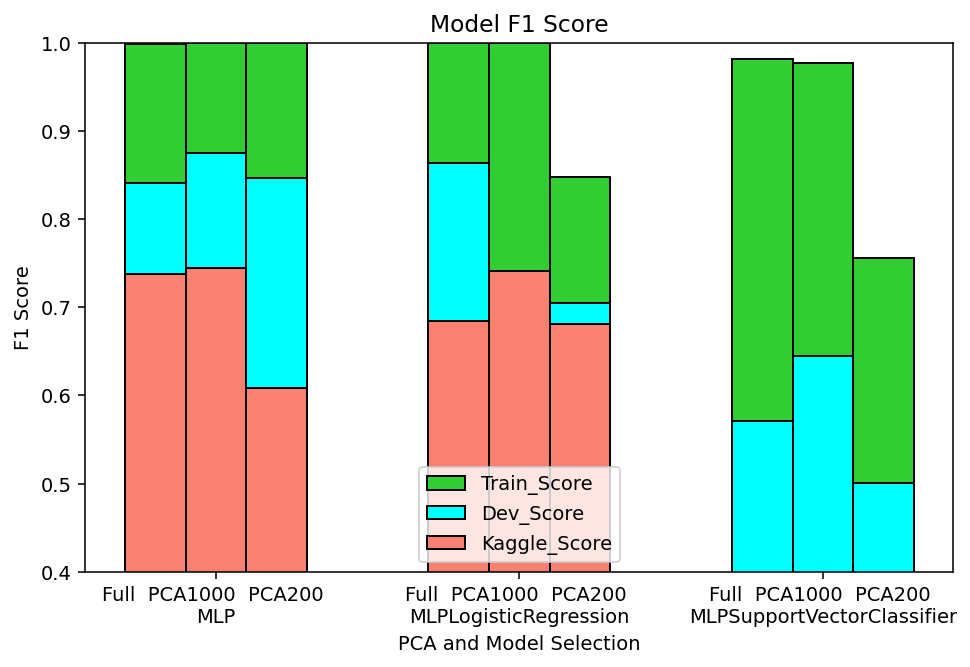

In [200]:

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
N = 3
barWidth = 0.2

fig = plt.subplots(figsize =(8, 5))

# Full Attributes
Train_Score = [0.999009, 1, 0.981802 ]
Dev_Score = [0.840951, 0.863485, 0.570614 ]
Kaggle_Score = [0.73809, 0.68421, 0]
br1 = np.arange(len(Train_Score))
p1 = plt.bar(br1, Train_Score, color='limegreen', width=barWidth,edgecolor='black')
p2 = plt.bar(br1, Dev_Score, color='cyan', width=barWidth,  bottom=0,edgecolor='black')
p3 = plt.bar(br1, Kaggle_Score, color='salmon', width=barWidth, bottom=0,edgecolor='black')

# PCA=1000
Train_Score = [ 1, 1, 0.977649 ]
Dev_Score = [0.874801 , 0.704559 , 0.644360]
Kaggle_Score = [0.74418, 0.74074, 0]
br2 = [x + barWidth for x in br1]
p1 = plt.bar(br2, Train_Score, color='limegreen', width=barWidth, edgecolor='black')
p2 = plt.bar(br2, Dev_Score, color='cyan', width=barWidth, bottom=0,edgecolor='black')
p3 = plt.bar(br2, Kaggle_Score, color='salmon', width=barWidth, bottom=0,edgecolor='black')

# PCA=200
Train_Score = [1, 0.848178 , 0.755559 ]
Dev_Score = [0.846312 ,0.704559 , 0.501117 ]

Kaggle_Score = [0.60869, 0.68131, 0]
br3 = [x + barWidth for x in br2]
p1 = plt.bar(br3, Train_Score, color='limegreen', width=barWidth,edgecolor='black')
p2 = plt.bar(br3, Dev_Score, color='cyan', width=barWidth, bottom=0,edgecolor='black')
p3 = plt.bar(br3, Kaggle_Score, color='salmon', width=barWidth, bottom=0,edgecolor='black')

plt.ylabel('F1 Score')
plt.xlabel("PCA and Model Selection")
plt.title('Model F1 Score')


plt.xticks(br2,
        ['Full  PCA1000  PCA200 \nMLP', 'Full  PCA1000  PCA200 \nMLPLogisticRegression', 'Full  PCA1000  PCA200 \nMLPSupportVectorClassifier'], rotation=0)
  
plt.legend((p1[0], p2[0], p3[0]), ('Train_Score', 'Dev_Score', 'Kaggle_Score'), loc='lower center')
plt.ylim([0.4, 1])
plt.show()

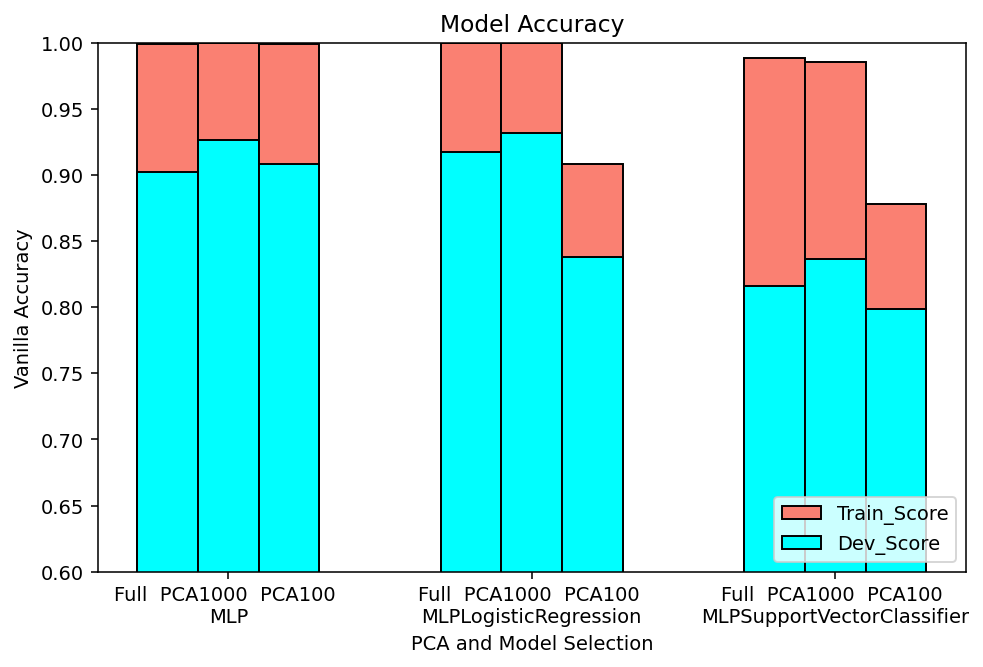

In [193]:

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
N = 3
barWidth = 0.2

fig = plt.subplots(figsize =(8, 5))

# Full Attributes
Train_Score = [0.9993535875888817, 1.0, 0.9883645765998708]
Dev_Score = [ 0.9022556390977443, 0.9172932330827067, 0.8157894736842105]
br1 = np.arange(len(Train_Score))
p1 = plt.bar(br1, Train_Score, color='salmon', width=barWidth,edgecolor='black')
p2 = plt.bar(br1, Dev_Score, color='cyan', width=barWidth,  bottom=0,edgecolor='black')

# PCA=1000
Train_Score = [1.0, 1.0, 0.9857789269553976]
Dev_Score = [0.9266917293233082, 0.9323308270676691, 0.8364661654135338]
br2 = [x + barWidth for x in br1]
p1 = plt.bar(br2, Train_Score, color='salmon', width=barWidth, edgecolor='black')
p2 = plt.bar(br2, Dev_Score, color='cyan', width=barWidth, bottom=0,edgecolor='black')

# PCA=200
Train_Score = [0.9993535875888817, 0.9088558500323206, 0.8784744667097608]
Dev_Score = [0.9088558500323206, 0.8383458646616542, 0.7988721804511278]
br3 = [x + barWidth for x in br2]
p1 = plt.bar(br3, Train_Score, color='salmon', width=barWidth,edgecolor='black')
p2 = plt.bar(br3, Dev_Score, color='cyan', width=barWidth, bottom=0,edgecolor='black')

plt.ylabel('Vanilla Accuracy')
plt.xlabel("PCA and Model Selection")
plt.title('Model Accuracy')


plt.xticks(br2,
        ['Full  PCA1000  PCA200 \nMLP', 'Full  PCA1000  PCA200 \nMLPLogisticRegression', 'Full  PCA1000  PCA200 \nMLPSupportVectorClassifier'], rotation=0)
  
plt.legend((p1[0], p2[0]), ('Train_Score', 'Dev_Score'), loc='lower right')
plt.ylim([0.6, 1])
plt.show()

## Test using model and save to local

In [33]:
TEST_ID_PATH = './id_data/test.data.txt'
TEST_DATA_PATH = './id_data/tweet-objects/'
TEST_DATA_JSON_PATH = './full_data/data_storage/test_data.json'

In [34]:
import os, json
import pandas as pd

json_files = [pos_json for pos_json in os.listdir(TEST_DATA_PATH) if pos_json.endswith('.json')]

list_of_data = []
for path in json_files:
    with open(TEST_DATA_PATH + path, "r") as f:
        list_of_data.append(json.load(f))

KeyboardInterrupt: 

In [ ]:
## Read in Json and do some preprocessing 
test_df = pd.DataFrame(list_of_data)

# Update source column
test_df["source"] = test_df["source"].apply(lambda x: re.findall(r'>[^<]*<',x)[0][1:-1])
# Get User ID
test_df["author_id"] = test_df["user"].apply(lambda x: x["id"])
# Filter Non English text into empty string
test_df.loc[test_df["lang"]!="en","text"] = "NA"
test_df.to_json(TEST_DATA_JSON_PATH)

In [206]:
X_test = join_data_id_label(None, TEST_ID_PATH, TEST_DATA_JSON_PATH, dropna_on_column = None)
X_test
## 2. Based on the values count, drop irrelevant features "reply_settings" too
X_test = X_test[['id','lang', 'text']]
# Use only text data and tokenize
X_test["clean_text"] = X_test["text"].apply(text_processing)
# Get BOF dataframe
X_test_BOW = get_bag_of_words(X_test["clean_text"])

## Keep training columns only
X_test_BOW = keep_training_columns_only(X_test_BOW, train_columns, default_value=0)

X_test_BOW.head(5)

,A,AB,ABC,ABCNews,ABOUT,AC,ACCORDING,ACCURATE,ACTED,AFFECT,...,youd,young,younger,yourbabazg,youre,youve,zaelefty,zero,zoom,zwinst
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [213]:
X_test_BOW.astype(bool).sum().sum()/X_train_BOW.astype(bool).sum().sum()

0.20294407200787587

In [212]:
X_dev_BOW.astype(bool).sum().sum()/X_train_BOW.astype(bool).sum().sum()

0.28132764521119497

In [211]:
X_train_BOW.astype(bool).sum().sum()/X_train_BOW.astype(bool).sum().sum()

1.0

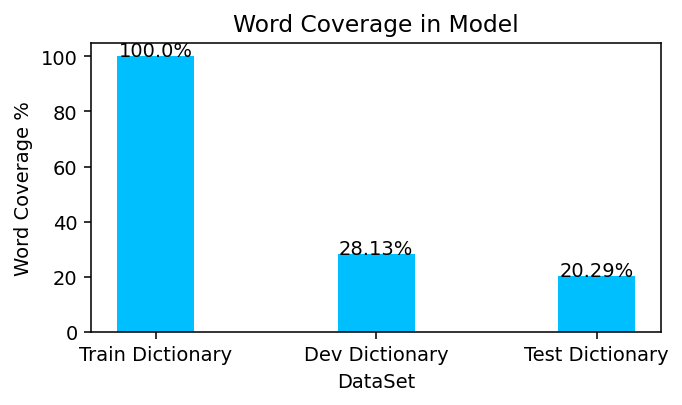

In [235]:
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["figure.autolayout"] = True

x = [1, 2, 3]
y = [100, 28.13, 20.29]

width = 0.35
fig, ax = plt.subplots()

pps = ax.bar(x, y, width, align='center', color="deepskyblue")

for p in pps:
   height = p.get_height()
   ax.text(x=p.get_x() + p.get_width() / 2, y=height+.10,
      s="{}%".format(height),
      ha='center')


plt.ylabel('Word Coverage %')
plt.xlabel("DataSet")
plt.title('Word Coverage in Model')


plt.xticks(x,
        ['Train Dictionary', 'Dev Dictionary', 'Test Dictionary'], rotation=0)
  

plt.show()

Too little information captured on test set! many words are not seen before

In [ ]:
X_test = X_test_BOW
## Transform using Trained Transformer

# StandardScaler
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=train_columns)

# PCA
X_test_scaled_reduced = pd.DataFrame(pca.transform(X_test_scaled))
X_test_scaled_reduced_pca600 = pd.DataFrame(pca600.transform(X_test_scaled))

In [ ]:
# generate the csv for prediction
def generate_csv(pred, csv_name):
    ids = pd.Index(range(len(pred)), name='Id')
    predictions = pd.DataFrame(pred, index=ids)
    predictions.columns = ['Predicted']
    predictions.to_csv(csv_name)

In [ ]:
y_pred = mlp_clf.predict(X_test_scaled_reduced)

In [ ]:
assert(len(y_pred)==558)
generate_csv(y_pred, "./test_pred/LR_PCA_200.csv")